# Advanced Algorithms Design with Classiq: Quantum Walk
------
### José Alejandro García González

## The problem

The objective of the present notebook is to implement the evolution operator of a Quantum Walk algorithm for a straight line consisting of 16 nodes labeled
from 0 to 15, as illustrated on the following picture.

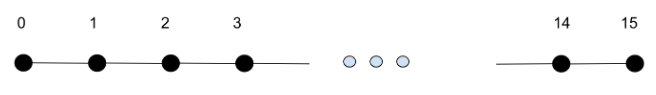 <br>
*Taken from Womanium Quantum+AI 2024 program Canva's page*

The goal of the evolution operator is to decide where a *walker* should move on the graph depending on where it is standing. For example, if our walker is on node **2**, the operator will decide that in the next step the walker will be in either node **1** or **3** with equal probability, or even on an
equal superposition of both nodes. Esentially, the evolution operator will move our *walker* around the graph one step at a time.

In order to achieve this, the operator is divided into two parts: an operator $C$, that will put our walker on a superposition of all possible nodes it can get to; and an operator $S$, that will "move" our walker to a different node. This way, applying $SC$ (in that order) will make our walker take a step around the graph.

## The $C$ operator

The C operator, for this problem, is defined as

$\hspace{6 cm}$ $C = \displaystyle\sum_{j=0}^{15} |j\rangle\langle j|\otimes(2|\partial_{j}\rangle\langle\partial_{j}| - I)$ $\hspace{2 cm}$ where $\hspace{2 cm}$ $|\partial_{j}\rangle = \dfrac{1}{\sqrt{deg(j)}} \displaystyle\sum_{k\in (j,k)}|k\rangle$

This may seem like a lot to take in, so let's go step by step. First, we note that we are going to use two quantum registers that will both encode the nodes of our graph, as can be told by the tensor product symbol on the first expression. We'll call the first register $|j\rangle$ and the second one $|k\rangle$, and they will have **4** qubits each, since we can encode numbers from 0 to 15 in binary with 4 bits. The second thing that we note is that we have a controlled operation: only when the first register is on a specific state $|j\rangle$ we apply the opperator $2|\partial_{j}\rangle\langle\partial_{j}| - I$ to the second register. So now, let´s see how we can build this operator.

We start by assuming we have acces to a certain unitary $U_{j}$ that allows us to prepare the $|\partial_{j}\rangle$ state, i.e., $U_{j}|0\rangle = |\partial_{j}\rangle$. Then we can write

$\hspace{10 cm}$ $2|\partial_{j}\rangle\langle\partial_{j}| - I = U_{j}(2|0\rangle\langle 0| - I)U_{j}^{\dagger}$

This follows the structure $UVU^{\dagger}$, which we can easily encode in Classiq with the `within_apply` function. And if we evaluate the operator $2|0\rangle\langle 0| - I$ on different basis states (where we consider the $|0\rangle$ state to be the all zeros state), we'll realize that it's the opposite as in Grover's diffusser operator, in the sense that it *marks* every state except the all zeros state. So, this can be easily implemented with
the `Phase Kickback` primitive, where we only leave the phase intact if our state is the all zeros state.

----

Putting it all together, we have:
1. A summation that can be done with a `for` loop or the `repeat` function from Classiq.
2. A controlled operation that can be done with the `control` function from Classiq.
3. An operator that can be implemented with the `within_apply` function and the `Phase Kickback` primitive.

-----

The only ingredient missing is the unitary $U_{j}$, and to understand how to implement it we can look at the desired state $|\partial_{j}\rangle$. We notice that we need to take the state of all zeros to a state that is an equal superposition of all nodes connected to node $j$. We can tell this by the
summation and the term $1/\sqrt{deg(j)}$, where $deg(j)$ is just the number of nodes connected to $j$ (for example, if $j=1$ we have $deg(1) = 2$, or if
$j = 0$ we have $deg(0) = 1$), as well as by the fact that the summation is over all nodes $k$ that are connected to the node $j$, which is what the term $k\in(j,k)$ means.

So, for example, for $j=0$ the only node connected to it is the node $k=0$, so we'll have $|\partial_{0}\rangle = |1\rangle$. <br>
On the other hand, for $j=1$ we have two adjacent nodes ($k=0$ and $k=2$), so we'll have $|\partial_{1}\rangle = \dfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$.

Now we are ready to code this operator

In [1]:
# We start by importing everything we need from Classiq´s library
from classiq import *

size = 4 # We define the size of our registers, which in this case is 4

In [2]:
@qfunc
def prepare_minus(x: QBit): # Function that prepares the |-> state that we'll use for phase kickback
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum): 
  aux^=(x!=0) # If x is different from 0, the statement is true and we do an inplace XOR between aux and 1. Otherwise the statement is false and we leave aux intact 


@qfunc
def zero_diffuzer(x: QNum): # Encoding of the 2|0><0| - I operator
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle) # We use a within_apply to encode the phase kickback, so that way we can uncompute the |-> state once
                                                # we no longer need it

Through the notebook we'll use the label `vertices` to refer to the register $|j\rangle$ and `adjacent_vertices` to refer to the register $|k\rangle$.

In [3]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum): # One element of the summation in C
    prob = [0 for m in range(2**size)] # We start with a state vector with 0s in all entries
    if i == 0:
        prob[i+1] = 1 # If we are on the 0th node, we can only move to the 1st node
    elif i == 2**size -1:
        prob[i-1] = 1 # If we are on the last node, we can only move to the previous node
    else: # Otherwise we have an equal probability of moving to the previous or the next node
        prob[i+1] = 0.5
        prob[i-1] = 0.5
    
    control(ctrl=vertices==i, 
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices), # Application of U_j
              action= lambda: zero_diffuzer(adjacent_vertices))) # Application of the zero diffuser


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for j in range(2**size): # Finally we do the summation
      C_iteration(j,vertices,adjacent_vertices)

## The $S$ operator

The $S$ operator turns out to be simpler and more straightforward than the $C$ operator, and in this case we can define it in a more general sense as

$\hspace{11 cm}$ $S = \displaystyle\sum_{(j,k)\in E}|k,j\rangle\langle j,k|$

In this case, we see that $S$ consist of a summation over all pairs of nodes $(j,k)$ that are connected, i.e., all nodes that form an edge ($E$ is the set of all edges). And, the action of $S$ is to swap both registers **only** if they form an edge. For example, the state $|0,1\rangle$ will be flipped to $|1,0\rangle$, but the state $|2,10\rangle$ will be left intact.

So, we need:
1. An oracle that allow us to check if two nodes have an edge between them.
2. A bitwise `SWAP` function to swap the order of the nodes. 

In the case of the oracle, we can already tell that nodes form an edge if they are adjacent to each other, so we can easily check this by asking if the
difference between two edges is either 1 or -1 (equivalent to asking if the absolute value of their difference is 1).

In [4]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1)) # If the nodes form an edge, we set the res qubit to state |1>


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

In [5]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1, # If the res qubit is set to state |1>
        operand= lambda: bitwise_swap(vertices,adjacent_vertices)) # We perform the bitwise swap

## Putting it all together

Finally, we just combine both operators on a single quantum program.

In [6]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices) # We create the first register
  hadamard_transform(vertices) # We put it in a superposition of all possible edges as a starting point for our walker
  allocate(size,adjacent_vertices) # We create the second register

  C_operator(vertices,adjacent_vertices) # Applying the C operator
  S_operator(vertices,adjacent_vertices) # Applying the S operator

In [7]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/64db74cc-a2d6-48ed-96ad-483eba4ed8bc?version=0.43.3


We're going to define a function that'll allow us to extract the width of our synthetized program, as well as the depth of the transpiled circuit, since we cannot extract the depth of the raw circuit. And since the transpiled circuit is a generic transpilation that takes the $U$ and $CX$ gates as the basis, it's only an approximation of the actual depth of our circuit. Depths of transpiled circuits for actual hardware providers will vary.

In [12]:
def print_depth_width(quantum_program): # Function to print both the width and the depth of our quantum program
    generated_circuit = QuantumProgram.parse_raw(quantum_program)
    print(f"Synthesized circuit width: {generated_circuit.data.width}, depth: {generated_circuit.transpiled_circuit.depth}")

In [13]:
print_depth_width(qprog)

Synthesized circuit width: 37, depth: 3154


As we can see, the circuit that our evolution operator acts on has 37 qubits and a "transpiled" depth of 3154, so we see that it's a quite deep circuit with lots of qubits. But, if we actually look at the circuit on Classiq's IDE we'll see that the depth we are able to extract is actually quite generous compared to the depth of the raw circuit, which is **5326**, as can be seen on the screen shot below.

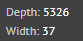

And since this circuit is so big, we are only going to include screen shots of certain sections of the circuit displayed on Classiq's IDE to be sure that our program looks like we wanted:

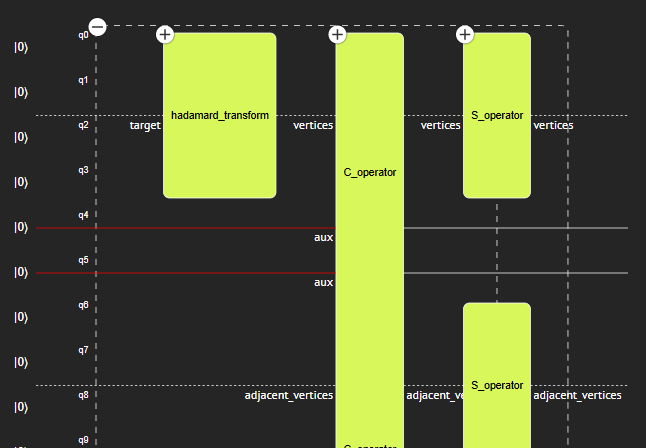

We can see from the screen shot that our circuit effectively applies first a hadamard transform over the `vertices` register, and then applies both the $C$ and $S$ operator over the `vertices` and `adjacent_vertices` registers.

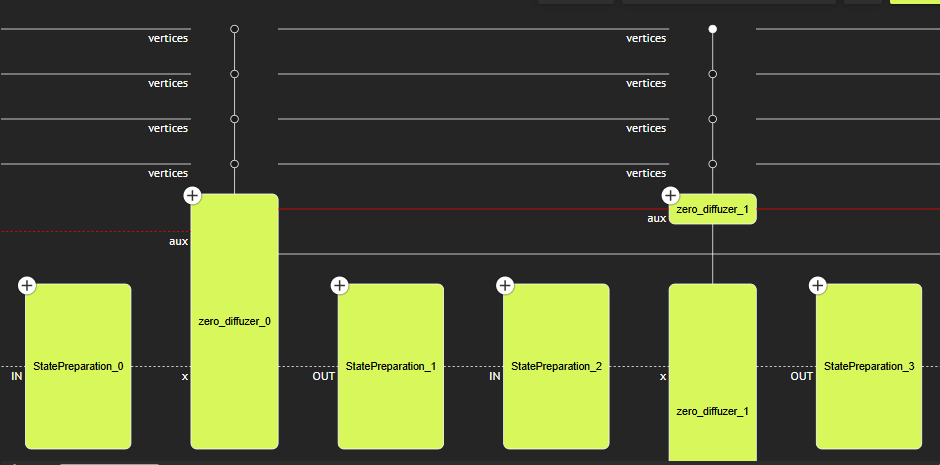

Next we see the structure of the $C$ operator above, with two elements of the sum following the `within_apply` structure of the zero diffuser being "sandwiched" by the state preparation and its inverse. However, we see something interesting: despite the fact that the three parts of the `within_apply` were controlled by the `vertices` register, the IDE only implemented the zero diffuser as a controlled operation. This is one of the many
advantages of Classiq's IDE, which makes our circuit simpler since it has less controlled operations, without needing any special input from the user. And the complexity reduction makes sense: since we are applying the inverse of the state preparation anyways, it doesn't matter if all of them happen for all possible states $|j\rangle$ because they'll get cancelled anyways.

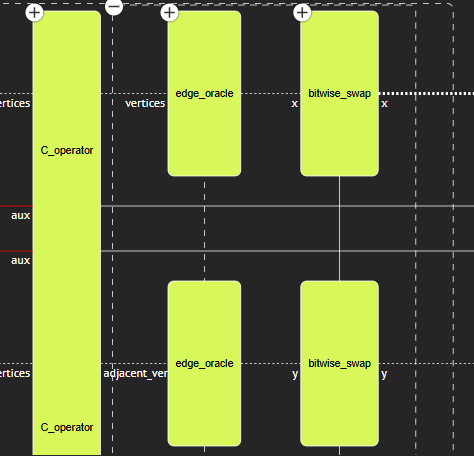

Finally, we have the structure of the $S$ operator, which applies the edge checking oracle followed by the bitwise swap, as expected.